## Train and test the final BrainTuning Contrastive Model

In [2]:
import numpy as np
import nibabel as nib
import nilearn 
import matplotlib.pyplot as plt
import os
from os.path import join as opj
import pandas as pd
import seaborn as sns
import glob
from nilearn import plotting
from nilearn.image import *
import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
from nilearn.plotting import plot_img, plot_epi
from nilearn.maskers import NiftiMasker
from sklearn.preprocessing import StandardScaler
import wandb
import pickle
from torch.utils.data import Dataset, DataLoader
from dataset import fMRI_Dataset
import torch
from torch import nn
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint

from pytorch_lightning.loggers import WandbLogger
from network import Encoder, ContrastiveModel
import torch
import torch.nn as nn
import pytorch_lightning as pl

/home/matteo/anaconda3/envs/braindiff/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [3]:
wandb.login()
wandb.init(project="BrainTuning",config={"model":"best_image_model"})

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matteoferrante. Use `wandb login --relogin` to force relogin


In [4]:
## load the data

train_datasets=[]
val_datasets=[]
test_datasets=[]

for subj in tqdm.tqdm(["CSI1","CSI2","CSI3","CSI4"]):

    subj_id = int(subj.split("CSI")[1])

    data_path =  f"/home/matteo/storage/brain_tuning/{subj}"

    train_fmri = np.load(opj(data_path, "train_fmri_top.npy"))
    val_fmri = np.load(opj(data_path, "val_fmri_top.npy"))
    test_fmri = np.load(opj(data_path, "test_fmri_top.npy"))

    ##load the images
    img_train = np.load(opj(data_path, "img_train.npy"),allow_pickle=True)
    img_val = np.load(opj(data_path, "img_val.npy"),allow_pickle=True)
    img_test = np.load(opj(data_path, "img_test.npy"),allow_pickle=True)

    ## load the features
    train_features = np.load(opj(data_path, "train_image_features.npy"))
    val_features = np.load(opj(data_path, "val_image_features.npy"))
    test_features = np.load(opj(data_path, "test_image_features.npy"))

    ## create the dataset
    train_dataset = fMRI_Dataset(train_fmri,img_train,train_features,subj_id)
    val_dataset = fMRI_Dataset(val_fmri,img_val,val_features,subj_id)
    test_dataset = fMRI_Dataset(test_fmri,img_test,test_features,subj_id)

    ## append the datasets
    train_datasets.append(train_dataset)
    val_datasets.append(val_dataset)
    test_datasets.append(test_dataset)





100%|██████████| 4/4 [00:11<00:00,  2.88s/it]


In [5]:
## Concatenate the datasets
train_dataset = torch.utils.data.ConcatDataset(train_datasets)
val_dataset = torch.utils.data.ConcatDataset(val_datasets)
test_dataset = torch.utils.data.ConcatDataset(test_datasets)


In [6]:
BATCH_SIZE = 512
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
## optimal parameter obtained from the hyperparameter search

act_fn = nn.Identity
base_channel_size = [2048]
hidden_dims = [1024]
latent_dim = 768

loss_type = "contrastive"
lr = 1e-4
temperature = 0.1
wd = 1e-5
alpha = 0.8

In [8]:
brain_model = ContrastiveModel(num_input_channels= 10000,
                                base_channel_size=base_channel_size, 
                                hidden_dims=hidden_dims,
                                latent_dim=latent_dim,
                                act_fn=act_fn,
                                loss_type=loss_type,
                                lr = lr,
                                wd = wd,
                                alpha=alpha)

# Set up early stopping to monitor 'val_loss'
early_stop_callback = EarlyStopping(monitor='val_loss', patience=1,verbose=True, mode='min')             # 'min' because we want to minimize val_loss
wandb_logger = WandbLogger()  # Logs the model and metrics to wandb


# Set up early stopping to monitor 'val_loss'
early_stop_callback = EarlyStopping(monitor='val_loss', patience=1,verbose=True, mode='min')             # 'min' because we want to minimize val_loss
wandb_logger = WandbLogger()  # Logs the model and metrics to wandb


# Create a unique checkpoint directory based on the run name or ID
run_name = wandb.run.name or wandb.run.id  # Use run name if available, otherwise use run ID
checkpoint_dir = os.path.join(data_path, "models", run_name)
os.makedirs(checkpoint_dir, exist_ok=True)

# Model checkpoint configuration
checkpoint_callback = ModelCheckpoint(monitor='val_loss',dirpath=checkpoint_dir,filename='brain_model-{epoch:02d}-{val_loss:.2f}',save_top_k=3,mode='min',)


# Initialize trainer with logger

trainer = pl.Trainer(max_epochs=20, devices=[1], callbacks=[early_stop_callback,checkpoint_callback],logger=wandb_logger ) # Add the wandb logger here

trainer.fit(brain_model, train_loader, val_loader)

/home/matteo/anaconda3/envs/braindiff/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/matteo/anaconda3/envs/braindiff/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performanc

Sanity Checking: 0it [00:00, ?it/s]

/home/matteo/anaconda3/envs/braindiff/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/home/matteo/anaconda3/envs/braindiff/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 255 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/matteo/anaconda3/envs/braindiff/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 5.428


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.222 >= min_delta = 0.0. New best score: 5.206


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.120 >= min_delta = 0.0. New best score: 5.086


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 5.025


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 4.991


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 4.974


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 4.971


Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 1 records. Best score: 4.971. Signaling Trainer to stop.


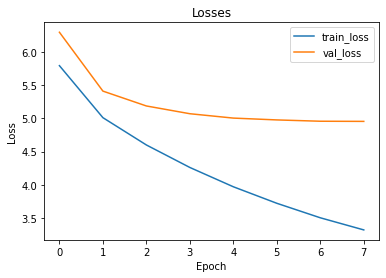

<Figure size 432x288 with 0 Axes>

In [9]:
## plot the losses
output_path = "/home/matteo/storage/brain_tuning/"

plt.plot(brain_model.train_history['train_loss'], label='train_loss')
plt.plot(brain_model.val_history['val_loss'][:-1], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses')

plt.show()

## save the plot
plt.savefig(opj(output_path, "losses.png"))

In [10]:
# from image_evaluation import *
# import importlib
# import image_evaluation
# importlib.reload(image_evaluation)
from image_evaluation import *


## Evaluation

In [11]:
results_df, similarity_matrices, results = evaluate_and_log(test_loader,brain_model)


100%|██████████| 6/6 [00:17<00:00,  2.87s/it]


Starting evaluation...
Evaluating metrics for subject 1...
Computed similarity matrix for subject 1.
Top-1 Accuracy: 0.0418, Top-5 Accuracy: 0.1572 for subject 1.
Identification accuracy for subject 1: 0.9030
Logged top-5 retrievals for subject 1.
Evaluating metrics for subject 2...
Computed similarity matrix for subject 2.
Top-1 Accuracy: 0.0317, Top-5 Accuracy: 0.1141 for subject 2.
Identification accuracy for subject 2: 0.8673
Logged top-5 retrievals for subject 2.
Evaluating metrics for subject 3...
Computed similarity matrix for subject 3.
Top-1 Accuracy: 0.0342, Top-5 Accuracy: 0.1179 for subject 3.
Identification accuracy for subject 3: 0.8715
Logged top-5 retrievals for subject 3.
Evaluating metrics for subject 4...
Computed similarity matrix for subject 4.
Top-1 Accuracy: 0.0214, Top-5 Accuracy: 0.0771 for subject 4.
Identification accuracy for subject 4: 0.8498
Logged top-5 retrievals for subject 4.
Evaluation complete. Results loaded to wandb.


In [12]:
results_df

,Subject,Identification Accuracy (%),ID Accuracy Baseline (%),Top-1 Accuracy (%),Top1 Baseline (%),Top1 Improvement Over Baseline,Top-5 Accuracy (%),Top5 Baseline (%),Top5 Improvement Over Baseline
0,1,90.297427,50,4.182510,0.126743,33.0,15.716096,0.633714,24.8
1,2,86.732869,50,3.168568,0.126743,25.0,11.406844,0.633714,18.0
2,3,87.147517,50,3.422053,0.126743,27.0,11.787072,0.633714,18.6
3,4,84.983136,50,2.141328,0.214133,10.0,7.708779,1.070664,7.2


In [13]:
## save the results
results_df.to_csv(opj(output_path,"results_image_contrastive.csv"))

In [14]:
def get_good_example_indices(similarity_matrix, gt_images, num_examples=10):
    """
    Get indices of good examples where the retrieved images include the stimulus image in the top-5.
    
    Args:
        similarity_matrix (np.array): Cosine similarity matrix between predicted and ground truth embeddings.
        gt_images (list): List of ground truth images.
        num_examples (int): Number of good examples to retrieve.

    Returns:
        List of tuples: Each tuple contains (stimulus_index, top5_indices), where:
                        - stimulus_index is the index of the stimulus image.
                        - top5_indices are the indices of the top-5 retrieved images.
    """
    # Identify indices where the correct image is among the top-5 retrieved
    good_examples_indices = [
        i for i in range(len(gt_images)) if i in np.argsort(-similarity_matrix[i])[:5]
    ]
    
    # Randomly select up to `num_examples` from good examples
    if len(good_examples_indices) > num_examples:
        good_examples_indices = np.random.choice(good_examples_indices, num_examples, replace=False)
    
    # Gather (stimulus_index, top5_indices) for each good example
    example_indices = []
    for i in good_examples_indices:
        sim_scores = similarity_matrix[i]
        top5_indices = np.argsort(-sim_scores)[:5]
        example_indices.append((i, top5_indices.tolist()))

    return example_indices

good_example_indices = get_good_example_indices(similarity_matrices[1], results[1]["gt_images"])
good_example_indices  # [(stimulus_index, [top5_index1, top5_index2, ..., top5_index5]), ...]


[(570, [25, 403, 570, 207, 655]),
 (606, [606, 16, 774, 226, 54]),
 (144, [73, 76, 754, 241, 144]),
 (76, [557, 146, 241, 76, 222]),
 (186, [769, 625, 179, 5, 186]),
 (523, [89, 559, 463, 523, 392]),
 (782, [782, 590, 44, 498, 751]),
 (70, [473, 73, 70, 334, 349]),
 (150, [150, 483, 590, 44, 568]),
 (452, [241, 452, 73, 645, 345])]

In [15]:
def get_random_example_indices(similarity_matrix, gt_images, num_examples=10):
    """
    Get random indices to visualize general performance of the model, with the top-5 retrieved images.
    
    Args:
        similarity_matrix (np.array): Cosine similarity matrix between predicted and ground truth embeddings.
        gt_images (list): List of ground truth images.
        num_examples (int): Number of random examples to retrieve.

    Returns:
        List of tuples: Each tuple contains (stimulus_index, top5_indices), where:
                        - stimulus_index is the index of the stimulus image.
                        - top5_indices are the indices of the top-5 retrieved images.
    """
    # Select random indices for visualization
    random_indices = np.random.choice(range(len(gt_images)), num_examples, replace=False)
    
    # Gather (stimulus_index, top5_indices) for each random example
    example_indices = []
    for i in random_indices:
        sim_scores = similarity_matrix[i]
        top5_indices = np.argsort(-sim_scores)[:5]
        example_indices.append((i, top5_indices.tolist()))

    return example_indices

random_example_indices = get_random_example_indices(similarity_matrices[1], results[1]["gt_images"])
# random_example_indices  # [(stimulus_index, [top5_index1, top5_index2, ..., top5_index5]), ...]


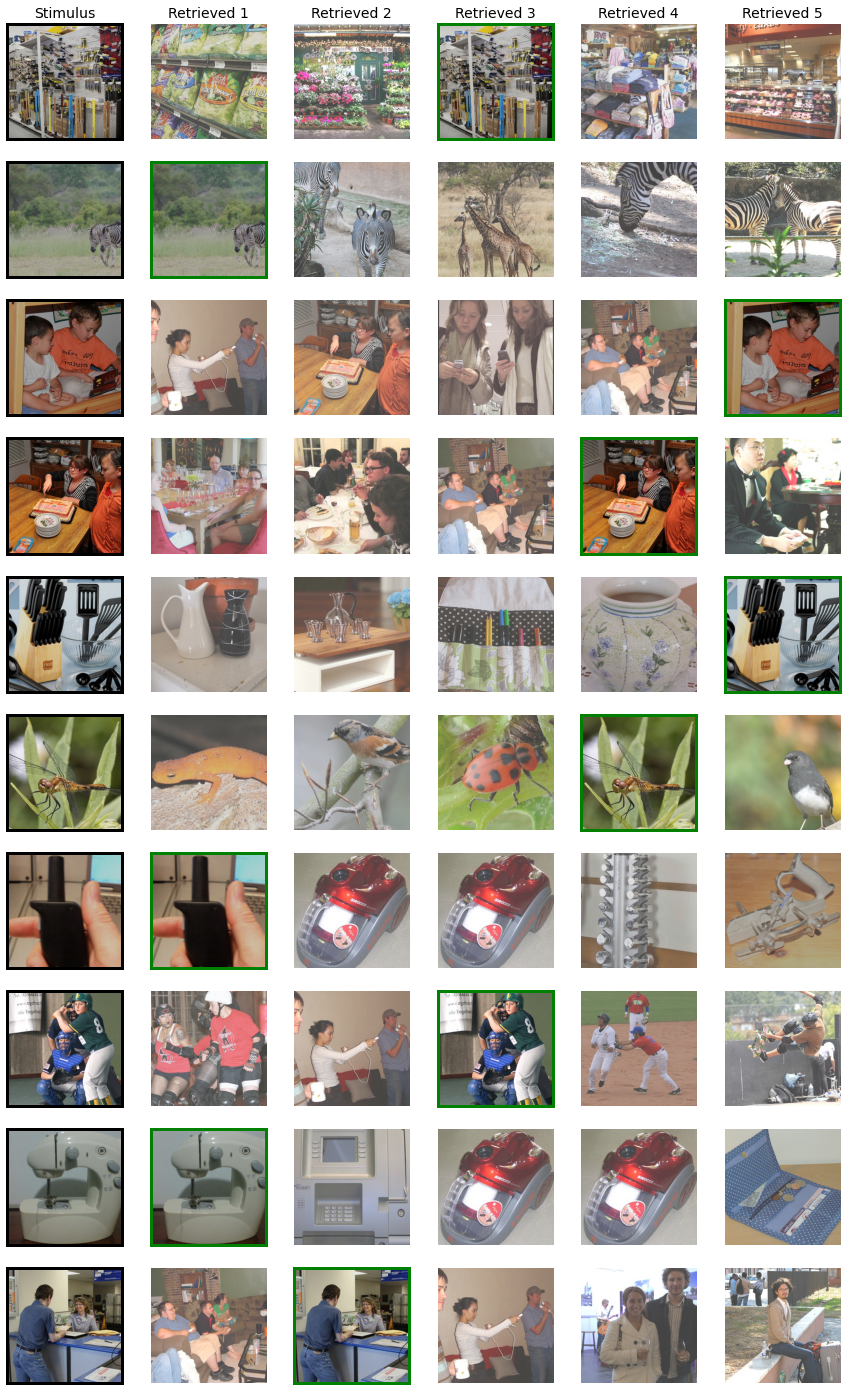

In [24]:
import matplotlib.pyplot as plt
def plot_examples(gt_images, example_indices,output_name="examples.png",alpha=0.75):
    """
    Plot the stimulus and top-5 retrieved images for each good example.

    Args:
        gt_images (list): List of ground truth images (as PIL images or arrays).
        example_indices (list): List of tuples with (stimulus_index, top5_indices) for good examples.
    """
    num_examples = len(example_indices)
    fig, axes = plt.subplots(num_examples, 6, figsize=(15, 2.5 * num_examples), facecolor="white")
    
    for i, (stimulus_index, top5_indices) in enumerate(example_indices):
        # Plot the stimulus image with a black border
        axes[i, 0].imshow(gt_images[stimulus_index].permute(1, 2, 0))
        axes[0, 0].set_title("Stimulus", fontsize=14)
        for spine in axes[i, 0].spines.values():
            spine.set_edgecolor("black")
            spine.set_linewidth(3)
        # Remove ticks and labels without turning off the entire axis
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])

        # Plot the top-5 retrieved images, adding a green border for the correct retrieval
        for j, top5_idx in enumerate(top5_indices):
            axes[0, j + 1].set_title(f"Retrieved {j + 1}", fontsize=14)
            
            # If the retrieved image is the correct one, add a green border
            if top5_idx == stimulus_index:
                axes[i, j + 1].imshow(gt_images[top5_idx].permute(1, 2, 0))

                for spine in axes[i, j + 1].spines.values():
                    
                    spine.set_edgecolor("green")
                    spine.set_linewidth(3)
            else:
                axes[i, j + 1].imshow(gt_images[top5_idx].permute(1, 2, 0),alpha=alpha)

                axes[i,j+1].axis('off')
            # Remove ticks and labels
            axes[i, j + 1].set_xticks([])
            axes[i, j + 1].set_yticks([])

    # plt.tight_layout()
    plt.savefig(output_name)
    plt.show()

plot_examples(results[1]["gt_images"], good_example_indices,output_name=opj(output_path, "good_examples.png"))

## save the plot


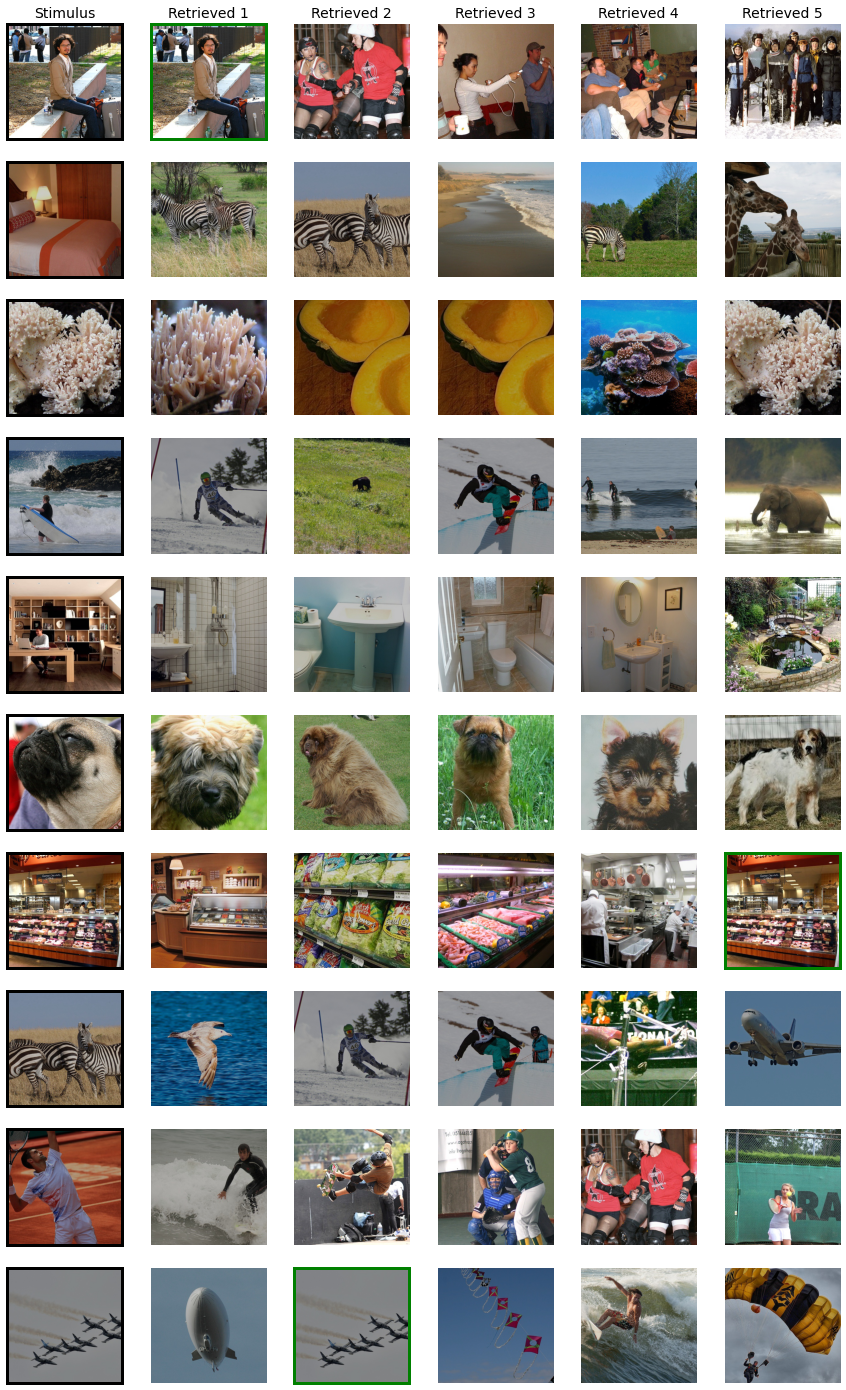

In [17]:
plot_examples(results[1]["gt_images"], random_example_indices,output_name=opj(output_path, "random_examples.png"),alpha=1)


In [18]:
# ## fit the decoding models
# from himalaya.ridge import RidgeCV
# from himalaya.backend import set_backend
# backend = set_backend("torch_cuda")  # or "torch_cuda"


# linear_decoding_models = []
# test_fmri_datas = []
# test_image_features = []

# for i in tqdm.trange(4):
#     fmri_train_sub = train_datasets[i].data
#     embeddings_train_sub = train_datasets[i].features

#     fmri_test_sub = test_datasets[i].data
#     embeddings_test_sub = test_datasets[i].features

#     test_fmri_datas.append(fmri_test_sub)
#     test_image_features.append(embeddings_test_sub)

#     #train the decoding model
#     decoding_model = RidgeCV(alphas=[1, 10, 100, 1e3, 1e4])
#     decoding_model.fit(backend.asarray(fmri_train_sub), backend.asarray(embeddings_train_sub))

#     linear_decoding_models.append(decoding_model)




In [19]:
# def organize_results_ensemble(loader,brain_model,decoding_models,test_fmri_datas):
#     # Initialize the dictionary to store results for each subject
#     results = defaultdict(lambda: {"y_pred": [], "y_gt": [], "gt_images": []})

#     # Run inference and store predictions and ground truth
#     with torch.no_grad():
#         for batch in tqdm.tqdm(loader):
#             x = batch["data"]
#             embeddings = batch["features"]
#             k = batch["subject_id"]
#             img = batch["images"]

#             y_hat_fmri, y_hat_embeddings = brain_model(x, embeddings, k=k)
#             for subject_index in torch.unique(k):
#                 mask = k == subject_index
#                 results[subject_index.item()]["y_pred"].append(y_hat_fmri[mask])
#                 results[subject_index.item()]["y_gt"].append(y_hat_embeddings[mask])
#                 results[subject_index.item()]["gt_images"].extend(img[mask])

#     # Concatenate the results for each subject
#     for subject_index in results:
#         results[subject_index]["y_pred"] = torch.cat(results[subject_index]["y_pred"], dim=0)
#         results[subject_index]["y_gt"] = torch.cat(results[subject_index]["y_gt"], dim=0)

#     ## check the shape
#     for subject_index in results:
#         print(subject_index,results[subject_index]["y_pred"].shape)
#         print(subject_index,results[subject_index]["y_gt"].shape)

#     print("Loading linear models..")

#     for i,subject_index in enumerate(results):
#         decoding_model = decoding_models[i]
#         test_fmri = test_fmri_datas[i]
#         y_pred = decoding_model.predict(backend.asarray(test_fmri)).numpy()
#         results[subject_index]["y_pred_linear"] = torch.tensor(y_pred)

    
    
    
#     return results

In [20]:
# def evaluate_and_log_ensemble(loader, brain_model, decoding_models, test_fmri_datas,linear_weight=0.5):
#     results = organize_results_ensemble(loader, brain_model, decoding_models, test_fmri_datas)
    
#     # Initialize lists to store results for each subject
#     subject_ids, top1_accuracies, top5_accuracies, id_accuracies, id_accuracy_baseline = [], [], [], [], []
#     top1_baseline, top5_baseline = [], []
#     top1_improvement_over, top5_improvement_over = [], []
#     similarity_matrices = {}
    
#     print("Starting evaluation...")
#     for subject_index, subject_data in results.items():
#         print(f"Evaluating metrics for subject {subject_index}...")
        
#         y_pred = subject_data["y_pred"]
#         y_pred_linear = subject_data["y_pred_linear"]
#         y_gt = subject_data["y_gt"]
#         gt_images = subject_data["gt_images"]

#         y_pred_np = y_pred.cpu().numpy()
#         y_pred_linear_np = y_pred_linear.cpu().numpy()
#         y_gt_np = y_gt.cpu().numpy()

#         # Compute similarity matrix
#         similarity_matrix = cosine_similarity(y_pred_np, y_gt_np)

#         #similarity matrix linear
#         similarity_matrix_linear = cosine_similarity(y_pred_linear_np, y_gt_np)

#         # Combine the similarity matrices
#         similarity_matrix = linear_weight*similarity_matrix_linear + (1-linear_weight)*similarity_matrix


#         similarity_matrices[subject_index] = similarity_matrix  # Store similarity matrix
#         print(f"Computed similarity matrix for subject {subject_index}.")

#         # Calculate Top-1 and Top-5 accuracy
#         top1_acc = (np.argmax(similarity_matrix, axis=1) == np.arange(len(y_gt_np))).mean()
#         top5_acc = np.mean([1 if i in np.argsort(-similarity_matrix[i])[:5] else 0 for i in range(len(y_gt_np))])
#         print(f"Top-1 Accuracy: {top1_acc:.4f}, Top-5 Accuracy: {top5_acc:.4f} for subject {subject_index}.")

#         # Identification accuracy
#         id_acc = identification_accuracy_fast(y_pred_np, y_gt_np)
#         print(f"Identification accuracy for subject {subject_index}: {id_acc:.4f}")

#         # Baseline performance (50% for identification accuracy as requested)
#         id_acc_baseline = 50

#         # Log metrics for this subject
#         wandb.log({
#             f"subject_{subject_index}_top1_acc": top1_acc,
#             f"subject_{subject_index}_top5_acc": top5_acc,
#             f"subject_{subject_index}_identification_accuracy": id_acc,
#         })

#         # Store results in lists
#         subject_ids.append(subject_index)
#         top1_accuracies.append(100*top1_acc)
#         top5_accuracies.append(100*top5_acc)
#         id_accuracies.append(100*id_acc)
#         id_accuracy_baseline.append(id_acc_baseline)
#         top1_baseline.append(100/similarity_matrix.shape[0])
#         top5_baseline.append(500/similarity_matrix.shape[0])

#         top1_improvement_over.append(top1_acc/(1/similarity_matrix.shape[0]))
#         top5_improvement_over.append(top5_acc/(5/similarity_matrix.shape[0]))


#         # Log a sample of 10 images and top-5 retrievals for each subject
#         sample_indices = np.random.choice(len(y_gt_np), 10, replace=False)
#         subject_table = wandb.Table(columns=["Stimulus Image", "Top 5 Retrieved Images"])

#         for i in sample_indices:
#             sim_scores = similarity_matrix[i]
#             top5_indices = np.argsort(-sim_scores)[:5]
#             top5_images = [wandb.Image(gt_images[idx]) for idx in top5_indices]  # Convert to wandb.Image
#             stimulus_image = wandb.Image(gt_images[i])  # Convert stimulus to wandb.Image
#             subject_table.add_data(stimulus_image, top5_images)
        
#         print(f"Logged top-5 retrievals for subject {subject_index}.")
        
#         # Log the table for each subject
#         wandb.log({f"subject_{subject_index}_Top5_Retrievals": subject_table})

#     print("Evaluation complete. Results loaded to wandb.")
    
#     # Create a DataFrame to store overall results per subject
#     results_df = pd.DataFrame({
#         "Subject": subject_ids,
#         "Identification Accuracy (%)": id_accuracies,
#         "ID Accuracy Baseline (%)": id_accuracy_baseline,
#         "Top-1 Accuracy (%)": top1_accuracies,
#         "Top1 Baseline (%)": top1_baseline,
#         "Top1 Improvement Over Baseline": top1_improvement_over,
#         "Top-5 Accuracy (%)": top5_accuracies,
#         "Top5 Baseline (%)": top5_baseline,
#         "Top5 Improvement Over Baseline": top5_improvement_over
#     })

#     # Return the results dictionary and similarity matrices for further analysis or visualization
#     return results_df, similarity_matrices, results

In [21]:
# results_ensemble_df, similarity_ensemble_matrices, results_ensemble = evaluate_and_log_ensemble(test_loader, brain_model, linear_decoding_models, test_fmri_datas)

In [22]:
# results_df

In [23]:
# results_ensemble_df